---
Concept relevance analysis
---


**Description:**  
Selection of Channels using Random Sampling 
### Additional Comments
### Author: Viswambhar Yasa

### Date: 09-01-2024

**Contact Information:**  
Email: [yasa.viswambhar@gmail.com](mailto:yasa.viswambhar@gmail.com)

In [1]:
import os
import io
import sys
import torch
import random
from PIL import Image
from pathlib import Path
from crp.image import imgify
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import save_image

In [12]:
notebook_directory = Path().resolve().parent
sys.path.insert(0,str(notebook_directory.parent))
from experiment.helper_functions import load_dict
from sentinelmodels.pretrained_models import buildmodel
from sentinelmodels.preprocessing import SentinelDataset
from interpet.concept.conceptrelevance import ConceptRelevance

In [14]:
config={    
                "root_dir":r'D:/master-thesis/Dataset/anthroprotect',
                "datasplitfilename": r"infos.csv",
                "n_classes":2,
                "datasaved":True,
                "device":"cpu",
                "models":["alexnet","vgg16","resnet18"],
                "modelweightpaths":[r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/alexnet_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/vgg16_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/resnet18_best_model.pth",
                                    ],
                "cmap":"hot",
                "symmetric":False,
                "level":1
                }

datafilepath=r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/data/wilderness_data.pkl"

loaded_data = dictionary = load_dict(datafilepath)
# Accessing the loaded images and labels
images = loaded_data["images"][-1,:,:,:].unsqueeze(dim=0).to(config["device"])
#images = loaded_data["images"].to(config["device"])

labels = loaded_data["labels"]

input_image_name="wilderness_data_random.png"
image_path = os.path.join(r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/",input_image_name)
save_image(F.pad(images, (2, 2, 2, 2), mode='constant', value=0), image_path, nrow=1, padding=0)

In [15]:
modelindex=-1
model=buildmodel(model_type=config["models"][modelindex],multiclass_channels=config["n_classes"],modelweightpath=config["modelweightpaths"][modelindex]).to(config["device"])
Concepts=ConceptRelevance(model,device=config["device"])
del model

In [16]:
def randomsamples(layerrelevance,numofsamples=10):
    selected_indices={}
    for i in range(0,layerrelevance.shape[0]):
        if len(layerrelevance.shape)>2:
            relsum=layerrelevance[i,:,:,:].sum((-1,-2))
        else:
            relsum=layerrelevance[i,:]
        if numofsamples>relsum.shape[0]:
            numofsamples=relsum.shape[0]
        positive_indices = relsum.gt(0).nonzero(as_tuple=True)[0]
        random_indices = torch.randperm(positive_indices.size(0))[:numofsamples]
        selected_indices[i] = (positive_indices[random_indices].tolist(),relsum[random_indices].tolist())
    return selected_indices

In [18]:
def generate_randomconcepts(images,layer_name,output=[1],compositename="epsilonplus",canonizerstype="vgg16",output_type="max",record_layer=[],samplesize=10):
    conditions = [{"y":output}]
    batchsize=images.shape[0]
    heatmap,condrel,_=Concepts.conditional_relevance(images,condition=conditions,compositename=compositename,canonizerstype=canonizerstype,output_type=output_type,record_layer=record_layer)
    layerrelevance=condrel[layer_name]
    batchchannelrel=randomsamples(layerrelevance,samplesize)
    batchimages={}
    for k in range(0,batchsize):
        channelindex=batchchannelrel[k][0]
        channelindexrel=batchchannelrel[k][1]
        conditions=[]
        conditions += [{"y": output, layer_name: [channel]} for channel in channelindex]
        batchcondheatmap,_,_=Concepts.conditional_relevance(images[k,:,:,:].unsqueeze(dim=0),condition=conditions,compositename=compositename,canonizerstype=canonizerstype,output_type=output_type,record_layer=record_layer)
        selectedhmconditions = [{"y": output, layer_name:channelindex}]
        selectedcondheatmap,scm_relevance,_=Concepts.conditional_relevance(images[k,:,:,:].unsqueeze(dim=0),condition=selectedhmconditions,compositename=compositename,canonizerstype=canonizerstype,output_type=output_type,record_layer=record_layer)
        batchimages[k]=(selectedcondheatmap,batchcondheatmap,channelindex,channelindexrel)
    return heatmap,batchimages,scm_relevance

In [19]:
recordlayers=list(Concepts.layer_map.keys())
layer_name=recordlayers[-5]

In [20]:
output=[1]
samplesize=10

In [15]:
#%env CUDA_LAUNCH_BLOCKING=1

In [21]:
conditions = [{"y":output}]
batchsize=images.shape[0]
heatmap,condrel,_=Concepts.conditional_relevance(images,condition=conditions,compositename="epsilonplus",canonizerstype=config["models"][modelindex],output_type="max",record_layer=[layer_name])
layerrelevance=condrel[layer_name]
batchchannelrel=randomsamples(layerrelevance,samplesize)
batchimages={}
for k in range(0,batchsize):
    channelindex=batchchannelrel[k][0]
    channelindexrel=batchchannelrel[k][1]
    conditions=[]
    conditions += [{"y": output, layer_name: [channel]} for channel in channelindex]
    batchcondheatmap,_,_=Concepts.conditional_relevance(images[k,:,:,:].unsqueeze(dim=0),condition=conditions,compositename="epsilonplus",canonizerstype=config["models"][modelindex],output_type="max",record_layer=[layer_name])
    selectedhmconditions = [{"y": output, layer_name:channelindex}]
    selectedcondheatmap,scm_relevance,_=Concepts.conditional_relevance(images[k,:,:,:].unsqueeze(dim=0),condition=selectedhmconditions,compositename="epsilonplus",canonizerstype=config["models"][modelindex],output_type="max",record_layer=[layer_name])
    batchimages[k]=(selectedcondheatmap,batchcondheatmap,channelindex,channelindexrel)

In [22]:
batchsize=images.shape[0]
print(batchsize)
if batchsize==1:
    index=0
    initialheatmap=imgify(heatmap,cmap=config["cmap"], symmetric=config["symmetric"],level=config["level"])
else:
    index=0
    initialheatmap=imgify(heatmap[index,:,:].unsqueeze(dim=0),cmap=config["cmap"], symmetric=config["symmetric"],level=config["level"])

1


In [32]:
layerconcepthm={}
for i,chindex in  enumerate(batchimages[index][2]):
    hm=batchimages[index][1][i,:,:].unsqueeze(dim=0)
    layerconcepthm[chindex]=(imgify(hm,cmap=config["cmap"], symmetric=config["symmetric"],level=config["level"]),hm.sum().item()*100,batchimages[index][-1][i]*100)

In [33]:
layerconcepthm

{53: (<PIL.Image.Image image mode=P size=256x256>,
  0.0010426974768051878,
  0.00041936305024137255),
 375: (<PIL.Image.Image image mode=P size=256x256>,
  0.09866282343864441,
  0.29165747109800577),
 212: (<PIL.Image.Image image mode=P size=256x256>,
  0.025222671683877707,
  0.3255775664001703),
 506: (<PIL.Image.Image image mode=P size=256x256>,
  0.016141068772412837,
  0.5639320239424706),
 437: (<PIL.Image.Image image mode=P size=256x256>,
  0.04236676904838532,
  0.03945452335756272),
 348: (<PIL.Image.Image image mode=P size=256x256>,
  0.04467651597224176,
  0.08467664010822773),
 112: (<PIL.Image.Image image mode=P size=256x256>,
  0.03786206943914294,
  0.02891213516704738),
 241: (<PIL.Image.Image image mode=P size=256x256>,
  0.46609481796622276,
  0.04902054788544774),
 306: (<PIL.Image.Image image mode=P size=256x256>,
  0.006272177415667102,
  0.05929177859798074),
 248: (<PIL.Image.Image image mode=P size=256x256>,
  0.0022451278709922917,
  0.5810803268104792)}

d:\finaldraft\ExplainingWilderness\thesis\Lib\site-packages\PIL\Image.py:3074: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


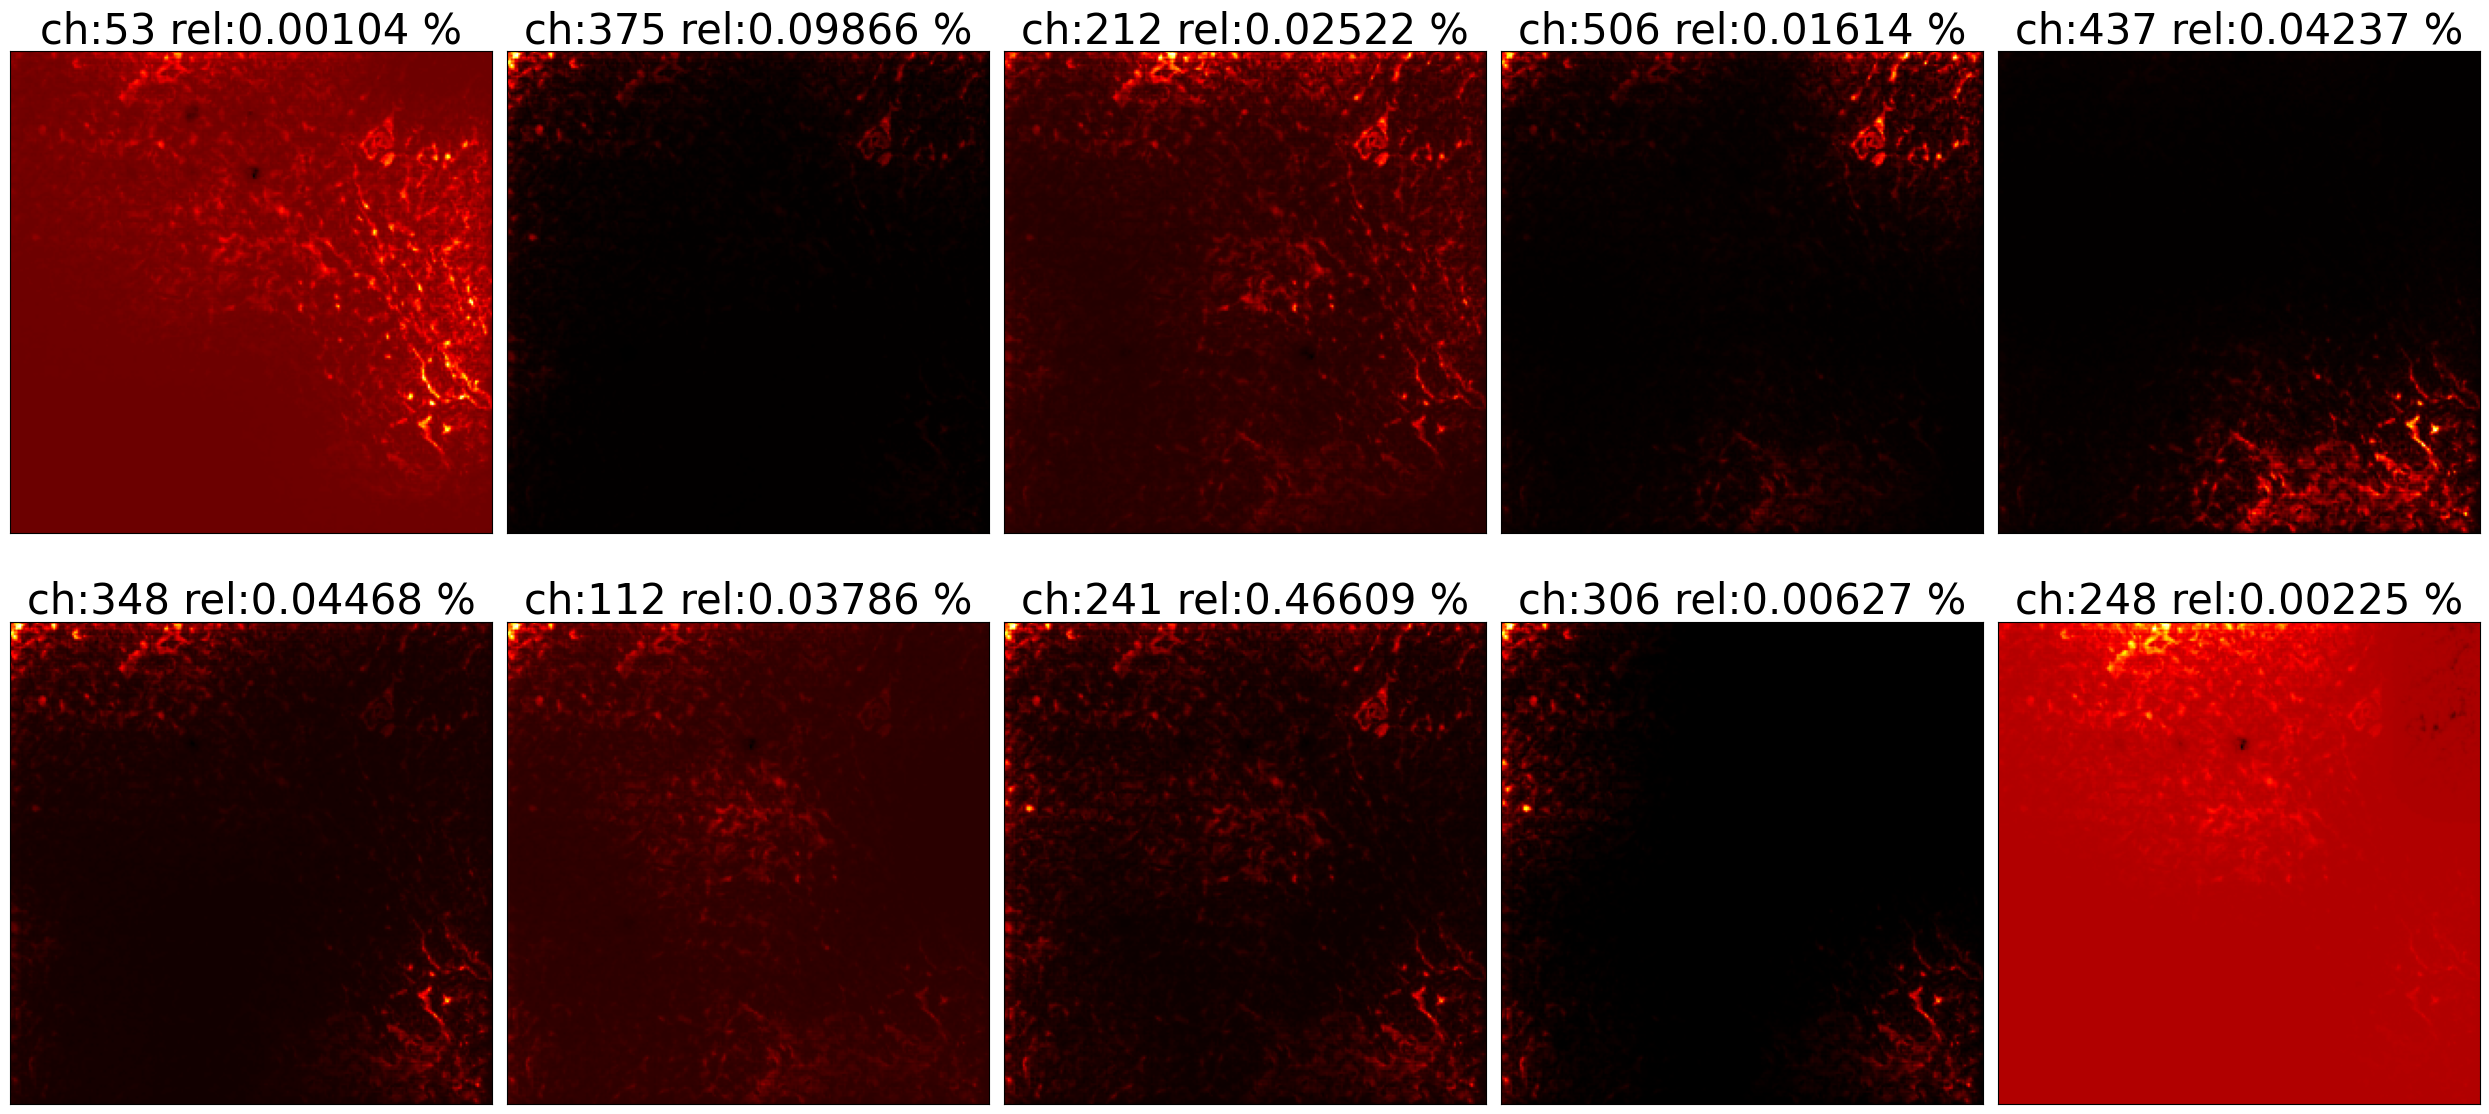

In [36]:
grid_rows = 2
grid_cols = int(len(list(layerconcepthm.keys()))/grid_rows)
fontsize=30
# Create a figure and a set of subplots
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(25, 12))

# Flatten the axes array for easy indexing
axes = axes.flatten()
cum_sum=0
# Iterate over the images and the axes
for i, (key, (img, val,initrel)) in enumerate(layerconcepthm.items()):
    # Plotting the PIL image
    axes[i].imshow(img)
    cum_sum+=val
    # Adding a title
    title = f"ch:{key} rel:{round(val,5)} %"  # Convert tensor to scalar
    axes[i].set_title(title,fontsize=fontsize,color='black')

    # Turn off axis
    axes[i].axis('on')
    axes[i].get_yaxis().set_visible(False)
    axes[i].get_xaxis().set_visible(False)

# Adjust layout
plt.tight_layout()
buf = io.BytesIO()
plt.savefig(buf, format='png',dpi=600)
buf.seek(0)

# Create a PIL image from the buffer
pil_img = Image.open(buf)

In [37]:
selectedheatmap=imgify(batchimages[index][0],cmap=config["cmap"], symmetric=config["symmetric"],level=config["level"])
initheatmap=imgify(heatmap[index,:,:],cmap=config["cmap"], symmetric=config["symmetric"],level=config["level"])

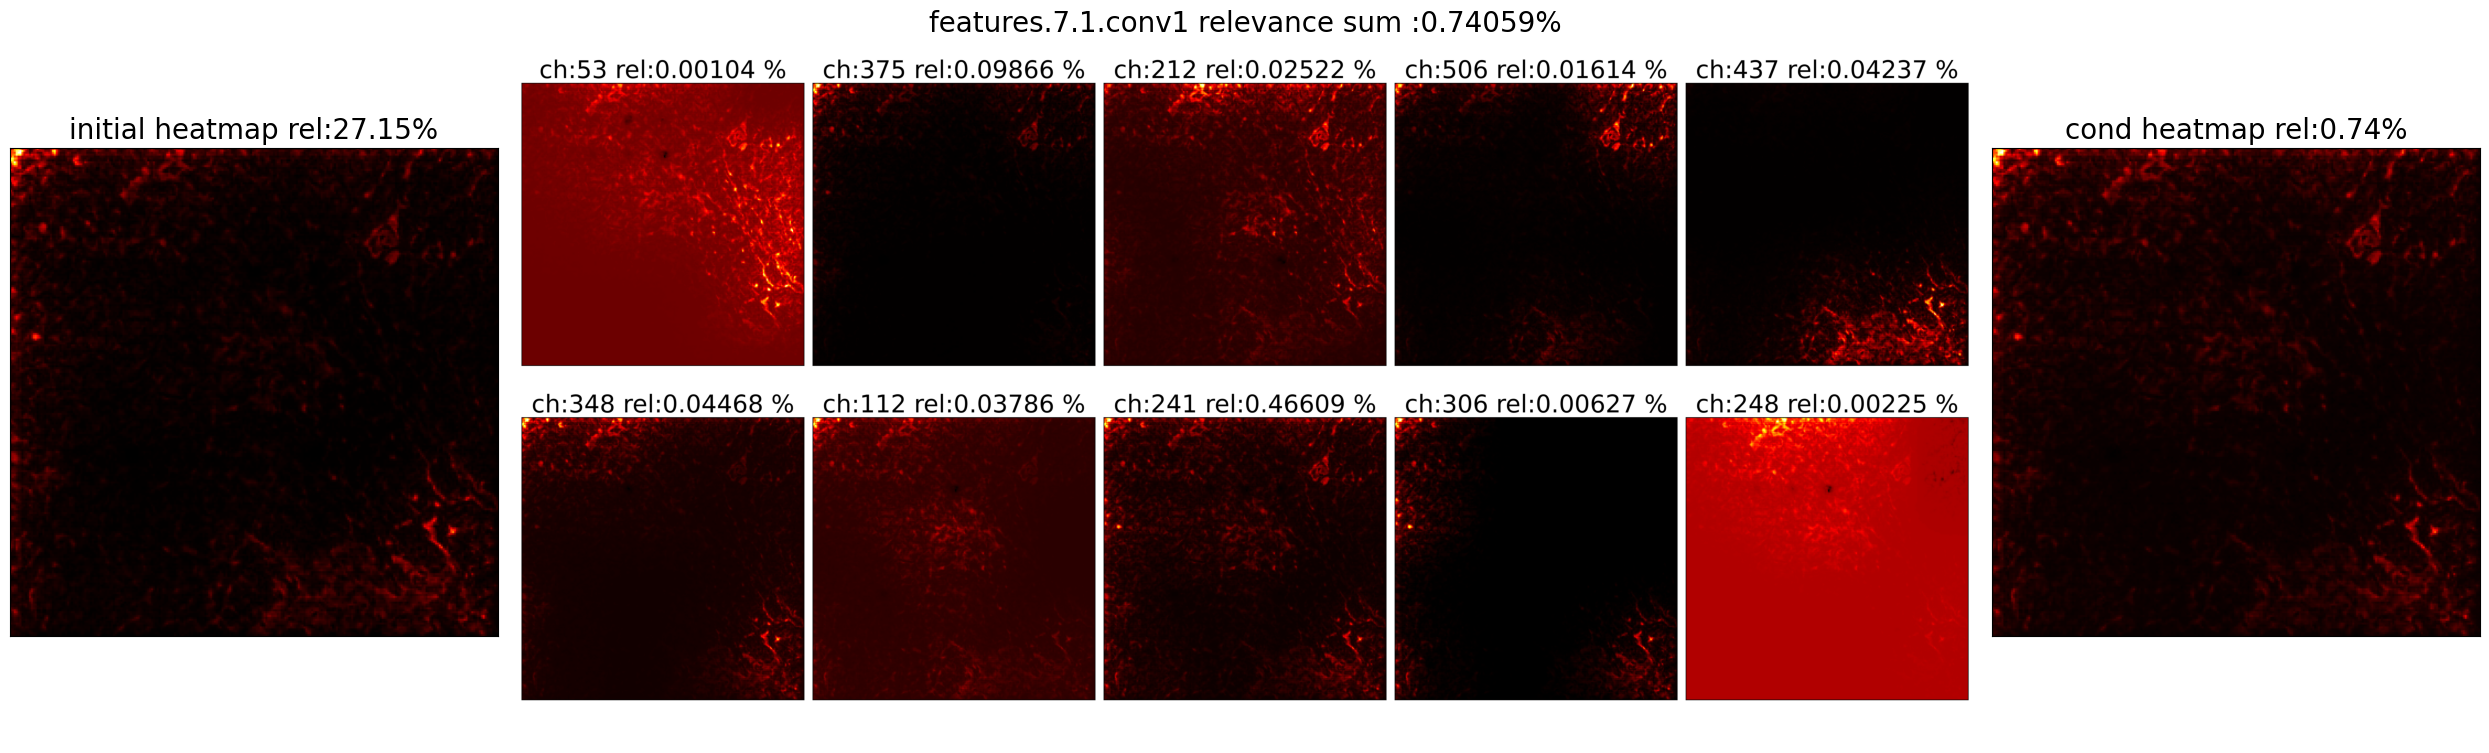

In [38]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(25, 12))  # Adjust the overall figure size as needed
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 3, 1])  # The third plot is twice as wide
fontsize=20
# Use the first column for the first image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(initheatmap)
ax1.set_title("initial heatmap rel:" +str(round(heatmap[index,:,:].sum().item()*100,2))+"%",fontsize=fontsize, color='black')
ax1.axis('on')
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)

# Use the second column for the second image
ax2 = fig.add_subplot(gs[2])
ax2.imshow(selectedheatmap)
ax2.set_title("cond heatmap rel:" +str(round(batchimages[index][0].sum().item()*100,2))+"%",fontsize=fontsize, color='black')
ax2.axis('on')
ax2.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)

# Use the third column for the third image
ax3 = fig.add_subplot(gs[1])
ax3.imshow(pil_img)
ax3.set_title(layer_name+" relevance sum :"+str(round(cum_sum,5))+"%",fontsize=fontsize)
ax3.axis('off')

plt.tight_layout()
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/heatmaps"
plt.savefig(os.path.join(saved_path,"./"+config["models"][modelindex]+"_"+layer_name+"_randomsamples_concepts.png"),dpi=600)
plt.show()